# GloVe - Twitter - CNN - RNN

En este notebook vamos a utilizar embeddings ya generados para entrenar distintos modelos basados en redes neuronales.

En particular vamos a utilizar un set de embeddings creado a partir de tweets.

El armado de los modelos está inspirado en las recomendaciones del siguiente paper https://arxiv.org/pdf/1510.03820.pdf


In [ ]:
import pandas as pd
from datetime import datetime
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Embedding, concatenate, Input, average
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
from keras.utils import plot_model

def metrics(predictions, y_test):
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print(f'Verdaderos Negativos: {tn}')
    print(f'Falsos Negativos: {fn}')
    print(f'Verdaderos Positivos: {tp}')
    print(f'Falsos Positivos: {fp}')
    print()
    print(f'precision score: {precision_score(y_test, predictions)}')
    print(f'recall score: {recall_score(y_test, predictions)}')
    print(f'f1 score: {f1_score(y_test,  predictions)}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Descargamos los embeddings y dejamos listo los archivos necesarios para poder trabajar.

In [ ]:
!wget -c http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2020-08-05 12:01:40--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-08-05 12:01:40--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-08-05 12:01:40--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [ ]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


## Preprocesamiento de los datos.
En primer lugar vamos a cargar los datasets de la competencia y realizar el mismo preprocesamiento realizado en el TP1 que consiste en limpiar el texto eliminando signos de puntuación, menciones, hashtags y urls.


In [ ]:
url_train = 'https://raw.githubusercontent.com/fsicardir/datos-tp2/master/dataset/train.csv?token=AFVAIUW66UE3NA5X2SYXNPC7GHGJY'
url_test = 'https://raw.githubusercontent.com/fsicardir/datos-tp2/master/dataset/test.csv?token=AFVAIUUSBVEOOMDIFV4GU6C7GHGNK'

read_train = pd.read_csv(url_train)
read_test = pd.read_csv(url_test)

In [ ]:
df_train = read_train[['id', 'text', 'target']]
df_test = read_test[['id', 'text']]

# Limpiamos los datos de la forma usual
# Quitamos las urls
df_train['text'] = df_train['text'].str.replace(r'http:\/\/.*', '', regex=True).replace(r'https:\/\/.*', '', regex=True)
df_test['text'] = df_test['text'].str.replace(r'http:\/\/.*', '', regex=True).replace(r'https:\/\/.*', '', regex=True)

# Quitamos user mentions, signos de puntuación, hashtags y stopwords.
def clean_text(text):
    words = text.lower().split(' ')
    text = ' '.join([word for word in words if not word.startswith('@') and word not in stopwords.words('english')])
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

train_tweets = df_train['text'].tolist()
train_target = df_train['target']
test_tweets = df_test['text'].tolist()
len(train_tweets), len(train_target), len(test_tweets)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

(7613, 7613, 3263)

Ahora vamos a tokenizar los tweets y pasarlos a un formato en el cual reemplazaremos las palabras por sus índices en el tokenizador.

Esto es porque las redes necesitan como input valores numéricos, y haciendo este mapeo logramos transformar las palabras del tweet a números.

Estos índices luego estarán mapeados a los vectores pre-entrenados que descargamos anteriormente, formando así la matriz de embeddings que es la que utilizará la red en su capa de Embedding.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweets)
vocabulary_size = len(tokenizer.word_index) + 1



sequences_train = tokenizer.texts_to_sequences(train_tweets)

# Sabemos que el tweet más largo en palabras tiene 25 palabras.
# Vamos a agregar el padding "al final"
max_padding = 25
padded_vecs_train = pad_sequences(sequences_train, maxlen=max_padding, padding='post')

# Cargamos los embeddings de GloVe. Utilizaremos los de 200 dimensiones.
glove_dict = {}
with open('glove.twitter.27B.200d.txt') as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], dtype='float32')
      glove_dict[word] = vector

# Ahora vamos a crear una matriz que tendrá los embeddings de GloVe
# correspondientes a cada palabra de nuestro vocabulario.
# Esto se lo pasaremos como pesos a la capa de Embedding del modelo a entrenar.
embedding_dim = 200
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_dict.get(word, None)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Vamos a dividir el set de entrenamiento para obtener un set de validación
# y así comenzar a entrenar nuestro modelo.
X_train, X_test, y_train, y_test = train_test_split(padded_vecs_train, train_target, test_size=0.2, random_state=31)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6090, 25), (6090,), (1523, 25), (1523,))

In [ ]:
# Ahora creemos nuestro modelo, el cual tendrá una única capa de convolución,
# una capa de MaxPooling, una capa de Dropout y una capa final para hacer la clasificación.
# Este modelo dio 0.796 como score en Kaggle.
model = Sequential()
emb_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_padding, trainable=False)

model.add(emb_layer)
model.add(Conv1D(filters=100, kernel_size=5, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 25, 200)           3080600   
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 25, 100)           100100    
_________________________________________________________________
global_max_pooling1d_42 (Glo (None, 100)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 101       
Total params: 3,180,801
Trainable params: 100,201
Non-trainable params: 3,080,600
_________________________________________________________________


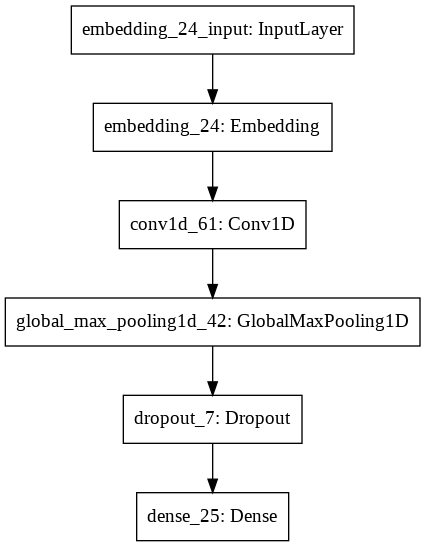

In [ ]:
plot_model(model)

In [ ]:
epochs = 20
model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/20
191/191 [==============================] - 3s 14ms/step - loss: 0.5150 - accuracy: 0.7585 - val_loss: 0.4310 - val_accuracy: 0.8011
Epoch 2/20
191/191 [==============================] - 3s 14ms/step - loss: 0.3990 - accuracy: 0.8227 - val_loss: 0.4221 - val_accuracy: 0.8135
Epoch 3/20
191/191 [==============================] - 3s 15ms/step - loss: 0.3472 - accuracy: 0.8517 - val_loss: 0.4259 - val_accuracy: 0.8122
Epoch 4/20
191/191 [==============================] - 3s 16ms/step - loss: 0.3032 - accuracy: 0.8762 - val_loss: 0.4344 - val_accuracy: 0.8063
Epoch 5/20
191/191 [==============================] - 3s 14ms/step - loss: 0.2611 - accuracy: 0.8989 - val_loss: 0.4503 - val_accuracy: 0.7984
Epoch 6/20
191/191 [==============================] - 3s 14ms/step - loss: 0.2423 - accuracy: 0.9097 - val_loss: 0.4501 - val_accuracy: 0.8129
Epoch 7/20
191/191 [==============================] - 3s 14ms/step - loss: 0.2114 - accuracy: 0.9217 - val_loss: 0.4705 - val_accuracy: 0.8116

In [ ]:
val_preds = model.predict_classes(X_test)

metrics(val_preds, y_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Verdaderos Negativos: 707
Falsos Negativos: 155
Verdaderos Positivos: 514
Falsos Positivos: 147

precision score: 0.7776096822995462
recall score: 0.7683109118086696
f1 score: 0.7729323308270677


In [ ]:
# Entrenamos la red con el total del set de datos y luego hacemos una predicción para la competencia.
sequences_test = tokenizer.texts_to_sequences(test_tweets)
padded_vecs_test = pad_sequences(sequences_test, maxlen=max_padding, padding='post')
model.fit(padded_vecs_train, train_target, epochs=epochs)

Epoch 1/20
238/238 [==============================] - 2s 10ms/step - loss: 0.2215 - accuracy: 0.9275
Epoch 2/20
238/238 [==============================] - 2s 10ms/step - loss: 0.1744 - accuracy: 0.9387
Epoch 3/20
238/238 [==============================] - 2s 10ms/step - loss: 0.1549 - accuracy: 0.9484
Epoch 4/20
238/238 [==============================] - 2s 10ms/step - loss: 0.1539 - accuracy: 0.9506
Epoch 5/20
238/238 [==============================] - 2s 10ms/step - loss: 0.1446 - accuracy: 0.9527
Epoch 6/20
238/238 [==============================] - 2s 10ms/step - loss: 0.1355 - accuracy: 0.9544
Epoch 7/20
238/238 [==============================] - 2s 10ms/step - loss: 0.1277 - accuracy: 0.9581
Epoch 8/20
238/238 [==============================] - 2s 10ms/step - loss: 0.1261 - accuracy: 0.9567
Epoch 9/20
238/238 [==============================] - 2s 10ms/step - loss: 0.1225 - accuracy: 0.9626
Epoch 10/20
238/238 [==============================] - 2s 10ms/step - loss: 0.1162 - accura

In [ ]:
kaggle_preds = model.predict_classes(padded_vecs_test)

result = df_test[['id']]
result['target'] = kaggle_preds
result.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
now = datetime.now(tz=None).strftime('%Y-%m-%dT%H-%M-%S')
result.to_csv(f'prediction_{now}.csv', encoding='utf-8', index=False)

In [ ]:
X_train.shape

(6090, 25)

# Conv1D con más dropout

In [ ]:
# Este modelo sacó 0.81029 en Kaggle.
# Pasamos a la api funcional para poder meter filtros en paralelo.
n_filters = 100

inputs = Input(shape=(max_padding))
emb = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_padding, trainable=False)(inputs)
drop = Dropout(0.5)(emb)

conv1 = Conv1D(n_filters, 5, padding='same', activation='relu')(drop)
conv1 = GlobalMaxPooling1D()(conv1)
conv1 = Dropout(0.5)(conv1)

out = Dense(1, activation='sigmoid')(conv1)

model = Model(inputs, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 25)]              0         
_________________________________________________________________
embedding_35 (Embedding)     (None, 25, 200)           3080600   
_________________________________________________________________
dropout_17 (Dropout)         (None, 25, 200)           0         
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 25, 100)           100100    
_________________________________________________________________
global_max_pooling1d_61 (Glo (None, 100)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)               

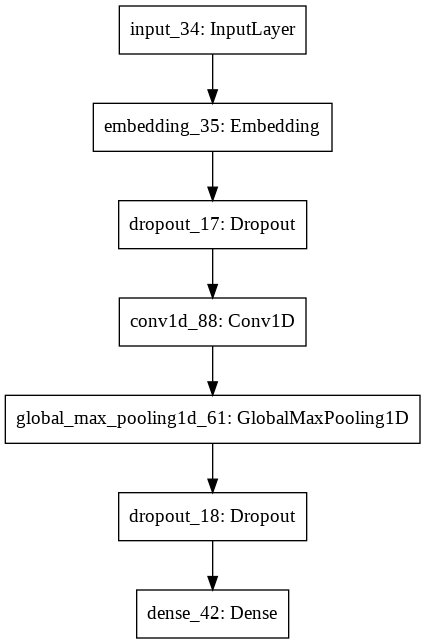

In [ ]:
plot_model(model)

In [ ]:
epochs = 20
model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/20
191/191 [==============================] - 3s 17ms/step - loss: 0.6377 - accuracy: 0.6869 - val_loss: 0.4505 - val_accuracy: 0.8142
Epoch 2/20
191/191 [==============================] - 3s 16ms/step - loss: 0.5139 - accuracy: 0.7571 - val_loss: 0.4538 - val_accuracy: 0.8102
Epoch 3/20
191/191 [==============================] - 3s 17ms/step - loss: 0.4806 - accuracy: 0.7795 - val_loss: 0.4493 - val_accuracy: 0.8024
Epoch 4/20
191/191 [==============================] - 3s 17ms/step - loss: 0.4588 - accuracy: 0.7887 - val_loss: 0.4375 - val_accuracy: 0.8129
Epoch 5/20
191/191 [==============================] - 3s 16ms/step - loss: 0.4605 - accuracy: 0.7867 - val_loss: 0.4444 - val_accuracy: 0.8129
Epoch 6/20
191/191 [==============================] - 3s 16ms/step - loss: 0.4414 - accuracy: 0.7984 - val_loss: 0.4382 - val_accuracy: 0.8175
Epoch 7/20
191/191 [==============================] - 3s 16ms/step - loss: 0.4249 - accuracy: 0.8131 - val_loss: 0.4294 - val_accuracy: 0.8155

In [ ]:
predictions = model.predict(X_test)
y_pred = [1 if pred > 0.5 else 0 for pred in predictions]
metrics(y_pred, y_test)

Verdaderos Negativos: 768
Falsos Negativos: 185
Verdaderos Positivos: 484
Falsos Positivos: 86

precision score: 0.8491228070175438
recall score: 0.7234678624813154
f1 score: 0.7812752219531881


In [ ]:
# Entrenamos la red con el total del set de datos y luego hacemos una predicción para la competencia.
sequences_test = tokenizer.texts_to_sequences(test_tweets)
padded_vecs_test = pad_sequences(sequences_test, maxlen=max_padding, padding='post')
model.fit(padded_vecs_train, train_target, epochs=epochs, verbose=False)

In [ ]:
k_preds_prob = model.predict(padded_vecs_test)
k_preds = [1 if pred > 0.5 else 0 for pred in k_preds_prob]

results = df_test[['id']]
results['target'] = k_preds
results.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
results.to_csv('conv1d-glove-twitter.csv', index=False)

# Conv1d con filtros de distinto tamaño y una capa oculta.

In [ ]:
# Este modelo sacó 0.81274 en Kaggle.
# Pasamos a la api funcional para poder meter filtros en paralelo.
# No hay justificación para el dropout en la capa de Embedding, it just worked.
n_filters = 200

inputs = Input(shape=(max_padding))
emb = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_padding, trainable=False)(inputs)
drop = Dropout(0.5)(emb)

conv1 = Conv1D(n_filters, 5, padding='same', activation='relu')(drop)
conv1 = GlobalMaxPooling1D()(conv1)
conv1 = Dropout(0.5)(conv1)

conv2 = Conv1D(n_filters, 4, padding='same', activation='relu')(drop)
conv2 =  GlobalMaxPooling1D()(conv2)
conv2 = Dropout(0.5)(conv2)

conv3 = Conv1D(n_filters, 3, padding='same', activation='relu')(drop)
conv3 = GlobalMaxPooling1D()(conv3)
conv3 = Dropout(0.5)(conv3)

concat = concatenate([conv1, conv2, conv3], axis=1)
drop_concat = Dropout(0.25)(concat)
out = Dense(128, activation='relu')(drop_concat)
out = Dropout(0.25)(out)
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_70"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding_44 (Embedding)        (None, 25, 200)      3080600     input_43[0][0]                   
__________________________________________________________________________________________________
dropout_47 (Dropout)            (None, 25, 200)      0           embedding_44[0][0]               
__________________________________________________________________________________________________
conv1d_108 (Conv1D)             (None, 25, 200)      200200      dropout_47[0][0]                 
______________________________________________________________________________________

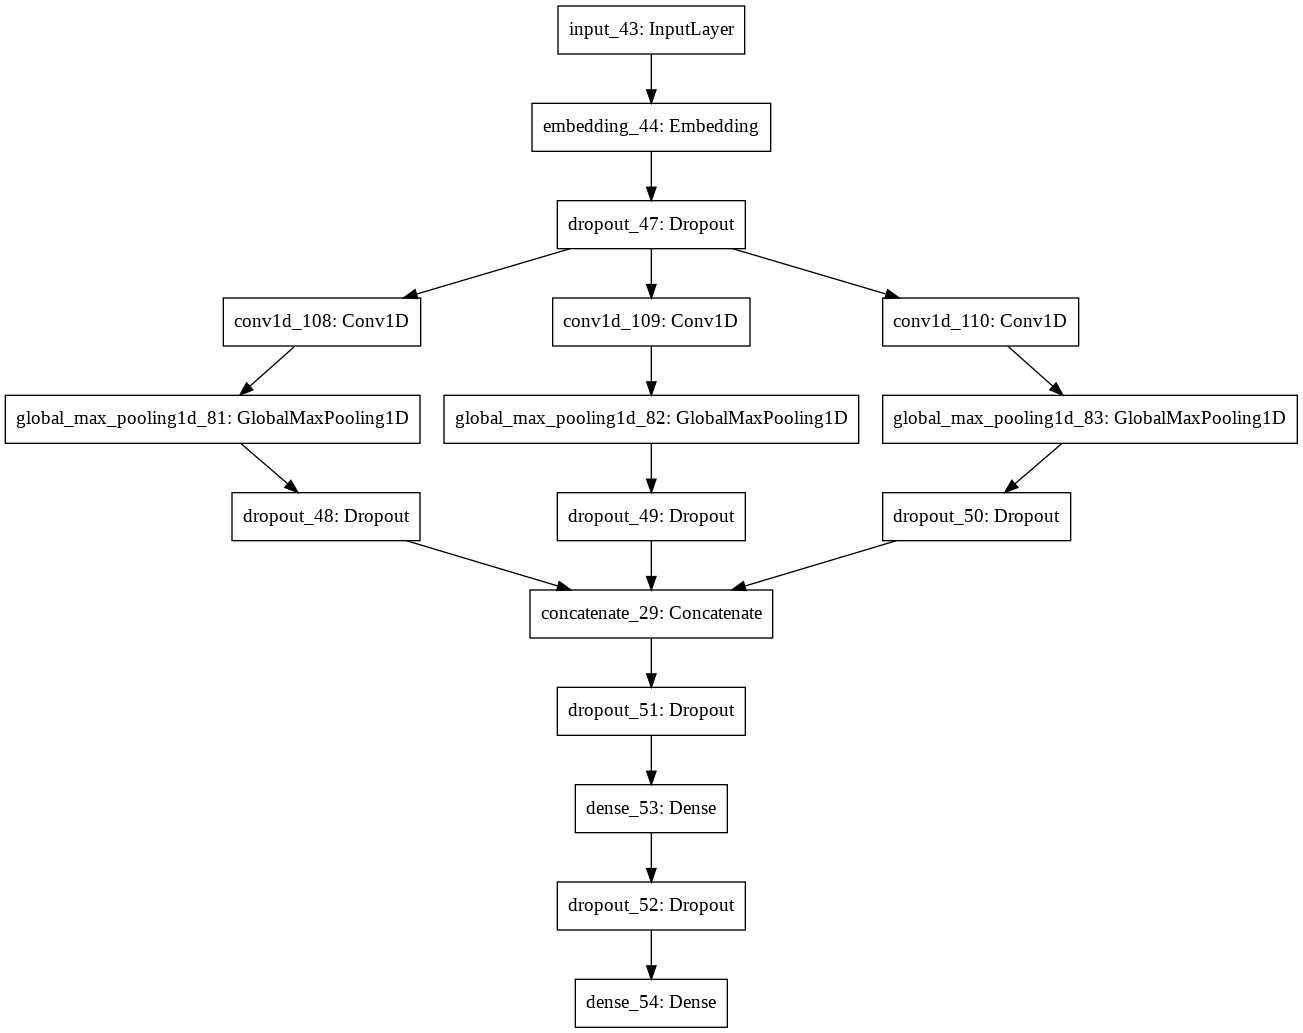

In [ ]:
plot_model(model)

In [ ]:
epochs = 20
model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/20
191/191 [==============================] - 9s 47ms/step - loss: 0.6127 - accuracy: 0.6911 - val_loss: 0.5058 - val_accuracy: 0.7932
Epoch 2/20
191/191 [==============================] - 9s 46ms/step - loss: 0.5202 - accuracy: 0.7514 - val_loss: 0.4826 - val_accuracy: 0.7859
Epoch 3/20
191/191 [==============================] - 9s 46ms/step - loss: 0.4935 - accuracy: 0.7755 - val_loss: 0.4629 - val_accuracy: 0.8116
Epoch 4/20
191/191 [==============================] - 9s 46ms/step - loss: 0.4859 - accuracy: 0.7741 - val_loss: 0.4545 - val_accuracy: 0.8116
Epoch 5/20
191/191 [==============================] - 9s 46ms/step - loss: 0.4713 - accuracy: 0.7831 - val_loss: 0.4485 - val_accuracy: 0.8043
Epoch 6/20
191/191 [==============================] - 9s 45ms/step - loss: 0.4500 - accuracy: 0.7862 - val_loss: 0.4377 - val_accuracy: 0.8142
Epoch 7/20
191/191 [==============================] - 9s 45ms/step - loss: 0.4504 - accuracy: 0.7993 - val_loss: 0.4397 - val_accuracy: 0.8175

In [ ]:
predictions = model.predict(X_test)
y_pred = [1 if pred > 0.5 else 0 for pred in predictions]
metrics(y_pred, y_test)

Verdaderos Negativos: 749
Falsos Negativos: 163
Verdaderos Positivos: 506
Falsos Positivos: 105

precision score: 0.8281505728314239
recall score: 0.7563527653213752
f1 score: 0.790625


In [ ]:
# Entrenamos la red con el total del set de datos y luego hacemos una predicción para la competencia.
sequences_test = tokenizer.texts_to_sequences(test_tweets)
padded_vecs_test = pad_sequences(sequences_test, maxlen=max_padding, padding='post')
model.fit(padded_vecs_train, train_target, epochs=epochs, verbose=False)

In [ ]:
k_preds_prob = model.predict(padded_vecs_test)
k_preds = [1 if pred > 0.5 else 0 for pred in k_preds_prob]

results = df_test[['id']]
results['target'] = k_preds
results.head()
results.to_csv('conv1d-multiple-filters-glove-twitter.csv', index=False)

# Conv1D con múltiples filtros y una capa oculta, electric boogaloo.

Vamos a agregar la keyword de cada tweet al texto del mismo como si fuera una palabra más.

La idea es agregar al tweet el embedding correspondiente a la keyword (si la hubiera).

Por lo tanto vamos a aumentar el max_padding de forma acorde.

In [ ]:
df_train['keyword'] = read_train['keyword']
df_test['keyword'] = read_test['keyword']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_train['keyword'].fillna("", inplace=True)
df_test['keyword'].fillna("", inplace=True)
df_train['keyword'].value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


                         61
fatalities               45
deluge                   42
armageddon               42
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [ ]:
df_train['keyword'] = df_train['keyword'].apply(lambda x: x.replace("%20", " "))
df_test['keyword'] = df_test['keyword'].apply(lambda x: x.replace("%20", " "))
df_train['text'] = df_train['text'] + " " + df_train['keyword']
df_test['text'] = df_test['text'] + " " + df_test['keyword']

In [ ]:
train_tweets = df_train['text'].tolist()
train_target = df_train['target']
test_tweets = df_test['text'].tolist()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweets)
vocabulary_size = len(tokenizer.word_index) + 1

sequences_train = tokenizer.texts_to_sequences(train_tweets)
sequences_test = tokenizer.texts_to_sequences(test_tweets)

max_padding = 30
padded_vecs_train = pad_sequences(sequences_train, maxlen=max_padding, padding='post')
padded_vecs_test = pad_sequences(sequences_test, maxlen=max_padding, padding='post')

# Ahora vamos a crear una matriz que tendrá los embeddings de GloVe
# correspondientes a cada palabra de nuestro vocabulario, incluyendo los keywords
# Esto se lo pasaremos como pesos a la capa de Embedding del modelo a entrenar.
embedding_dim = 200
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_dict.get(word, None)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

X_train, X_test, y_train, y_test = train_test_split(padded_vecs_train, train_target, test_size=0.2, random_state=31)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6090, 30), (6090,), (1523, 30), (1523,))

In [ ]:
# Este modelo no dio buenos resultados, sacó 0.79926 en Kaggle.
# Vamos a usar una configuración similar a la del paper en el que nos basamos
# para este notebook, en donde tendremos capas de convolución cuyos filtros serán
# de tamaño [2, 3, 4, 5]
# Entre los tantos intentos realizados, probamos mergear el output de cada capa de convolución
# de distintas formas, y no notamos diferencias significatorias así que en este caso vamos a dejar fijo average.
# Con o sin Dropout en la capa de Embedding, no notamos diferencia en la performance.

n_filters = 200
filter_dropout = 0.5
hidden_dropout = 0.5

inputs = Input(shape=(max_padding))
emb = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_padding, trainable=False)(inputs)

conv1 = Conv1D(n_filters, 5, activation='relu')(emb)
conv1 = GlobalMaxPooling1D()(conv1)
conv1 = Dropout(filter_dropout)(conv1)

conv2 = Conv1D(n_filters, 4, activation='relu')(emb)
conv2 =  GlobalMaxPooling1D()(conv2)
conv2 = Dropout(filter_dropout)(conv2)

conv3 = Conv1D(n_filters, 3, activation='relu')(emb)
conv3 = GlobalMaxPooling1D()(conv3)
conv3 = Dropout(filter_dropout)(conv3)

conv4 = Conv1D(n_filters, 2, activation='relu')(emb)
conv4 = GlobalMaxPooling1D()(conv4)
conv4 = Dropout(filter_dropout)(conv4)

merge = average([conv1, conv2, conv3, conv4])
out = Dense(64, activation='relu')(merge)
out = Dropout(hidden_dropout)(out)
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_229"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_129 (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_130 (Embedding)       (None, 30, 200)      3080600     input_129[0][0]                  
__________________________________________________________________________________________________
conv1d_443 (Conv1D)             (None, 26, 200)      200200      embedding_130[0][0]              
__________________________________________________________________________________________________
conv1d_444 (Conv1D)             (None, 27, 200)      160200      embedding_130[0][0]              
_____________________________________________________________________________________

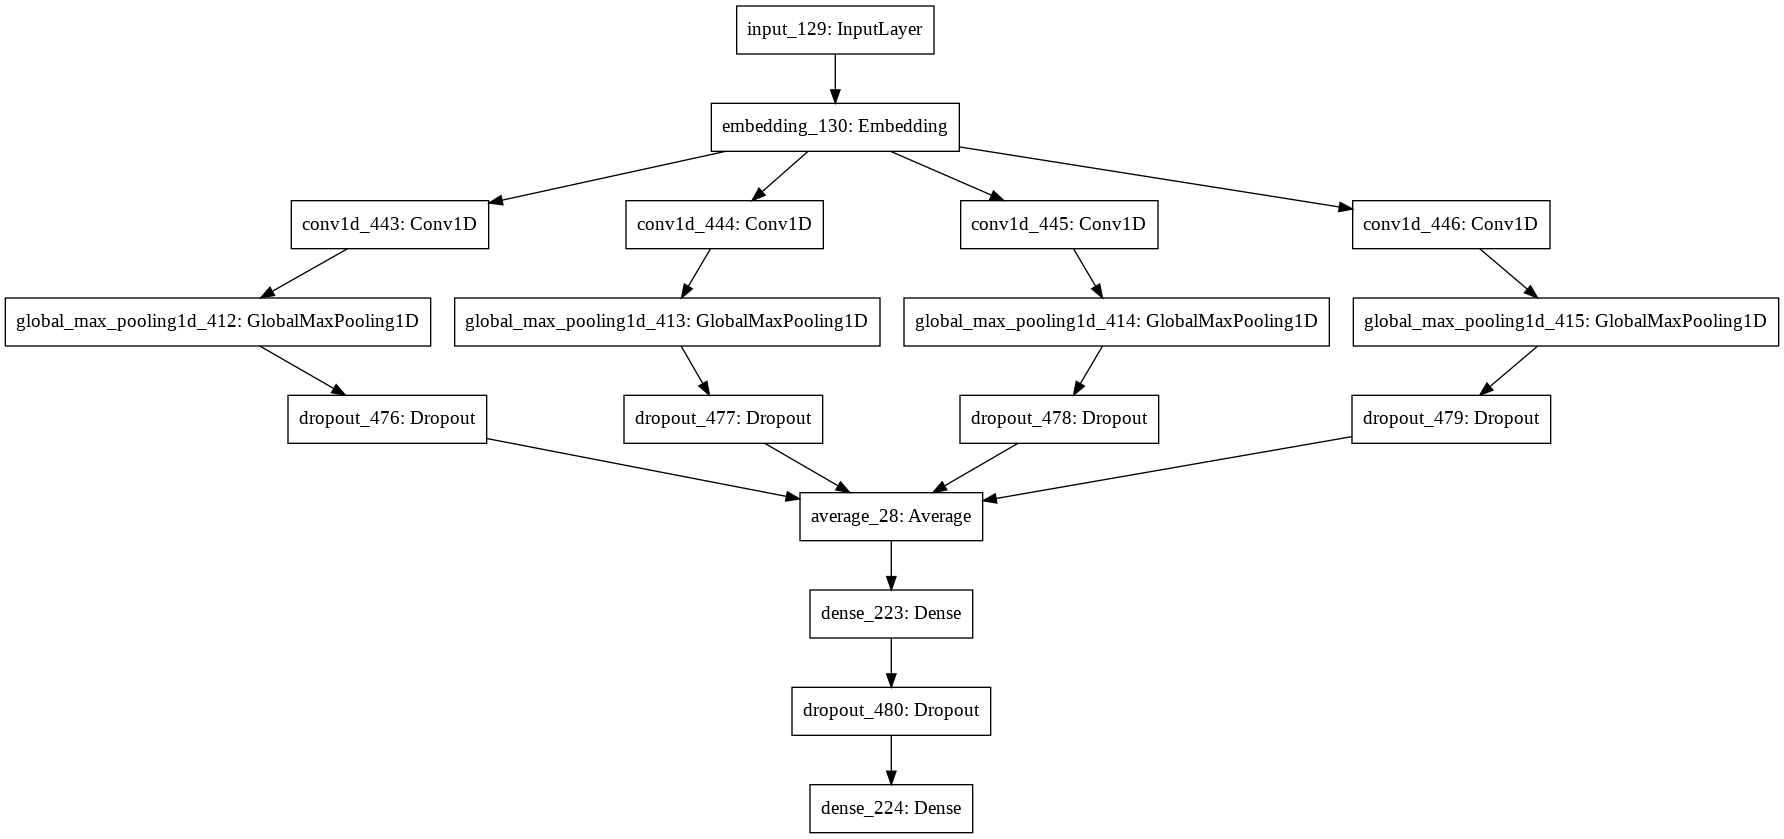

In [ ]:
plot_model(model)

In [ ]:
epochs = 10
model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/10
191/191 [==============================] - 11s 58ms/step - loss: 0.5291 - accuracy: 0.7466 - val_loss: 0.4421 - val_accuracy: 0.7919
Epoch 2/10
191/191 [==============================] - 11s 58ms/step - loss: 0.4339 - accuracy: 0.8069 - val_loss: 0.4253 - val_accuracy: 0.8168
Epoch 3/10
191/191 [==============================] - 11s 59ms/step - loss: 0.3640 - accuracy: 0.8414 - val_loss: 0.4424 - val_accuracy: 0.7932
Epoch 4/10
191/191 [==============================] - 12s 60ms/step - loss: 0.3164 - accuracy: 0.8658 - val_loss: 0.4537 - val_accuracy: 0.7971
Epoch 5/10
191/191 [==============================] - 11s 59ms/step - loss: 0.2678 - accuracy: 0.8905 - val_loss: 0.4722 - val_accuracy: 0.7971
Epoch 6/10
191/191 [==============================] - 11s 57ms/step - loss: 0.2089 - accuracy: 0.9236 - val_loss: 0.5138 - val_accuracy: 0.8037
Epoch 7/10
191/191 [==============================] - 11s 59ms/step - loss: 0.1817 - accuracy: 0.9345 - val_loss: 0.5763 - val_accuracy:

In [454]:
predictions = model.predict(X_test)

y_preds = [1 if pred > 0.5 else 0 for pred in predictions]
metrics(y_preds, y_test)

Verdaderos Negativos: 668
Falsos Negativos: 128
Verdaderos Positivos: 541
Falsos Positivos: 186

precision score: 0.7441540577716643
recall score: 0.8086696562032885
f1 score: 0.7750716332378222


In [455]:
model.fit(padded_vecs_train, train_target, epochs=epochs, verbose=False)
k_preds_prob = model.predict(padded_vecs_test)
k_preds = [1 if pred > 0.5 else 0 for pred in k_preds_prob]

results = df_test[['id']]
results['target'] = k_preds
results.head()
results.to_csv('conv1d-multiple-filters-glove-twitter-average.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
